In [1]:
import sys, subprocess, importlib, os
REPO_URL = "https://github.com/khayhamz31/d2v_copy"
REPO_DIR = "Dataset2Vec"

if not os.path.exists(REPO_DIR):
    subprocess.run(
        ["git", "clone", "--depth", "1", REPO_URL, REPO_DIR],
        check=True
    )
    print(f"Cloned repository into ./{REPO_DIR}")
else:
    print("dataset2vec already present in project root.")

Cloning into 'Dataset2Vec'...


Cloned repository into ./Dataset2Vec


### Environment Imports  
Core libraries, OpenML access, widgets for UI, and project modules for:
- downloading datasets  
- extracting traditional & D2V meta-features  
- aggregating runs  
- training meta-classifier and meta-regressor models  

In [5]:
import warnings
import openml
import ipywidgets as widgets
import time
import os
import pandas as pd
from IPython.display import clear_output, display
warnings.filterwarnings("ignore", category=RuntimeWarning)

# SET OPENML KEY HERE 
openml.config.apikey = ""
from datasets import (
    download_benchmark_suite,
    download_and_process_dataset,
    download_datasets_from_df
)

from qualities import extract_metafeatures_from_local_datasets

from d2v_qualities import extract_metafeatures_from_datasets

from runs import run_pipeline

from metaclassifier import run_meta_classifier

from metaregressor import run_meta_regressor_multioutput

from regressor_comparison import plot_regressor_as_classifier_results

# set random seed for reproducibility
random_seed = 411

### Benchmark Suite Selection  
Fetch OpenML benchmark suites with retry logic, display a dropdown selector, and download datasets from the chosen suite 

In [ ]:
max_retries = 3
delay = 5

for attempt in range(max_retries):
    try:
        suites_df = openml.study.list_suites(output_format="dataframe", status="all")
        break
    except openml.exceptions.OpenMLServerException:
        if attempt < max_retries - 1:
            time.sleep(delay)
        else:
            raise RuntimeError("Failed to fetch benchmark suites after multiple retries.")

suites_df["alias"] = suites_df["alias"].fillna("unnamed")
options = [(f"{alias} ({sid})", sid) for sid, alias in zip(suites_df["id"], suites_df["alias"])]

dropdown = widgets.Dropdown(
    options=options,
    description='Suite:',
    layout=widgets.Layout(width='60%')
)
output = widgets.Output()
selected_suite_info = {"id": None, "alias": None}

def on_dropdown_change(change):
    if change["type"] == "change" and change["name"] == "value":
        with output:
            clear_output()
            sid = change["new"]
            alias = next(label.split(" (")[0] for label, val in options if val == sid)
            selected_suite_info.update({"id": sid, "alias": alias})
            print(f"Downloading: {alias} ({sid})...")
            res = download_benchmark_suite(sid)
            print(f"{res['successful']}/{res['total']} downloaded, {res['failed']} failed.")

dropdown.observe(on_dropdown_change)
display(dropdown, output)

Dropdown(description='Suite:', layout=Layout(width='60%'), options=(('OpenML100 (14)', 14), ('OpenML-CC18 (99)…

Output()

### Meta-feature extraction 
1. Extracts meta-features from openml for the datasets downloaded
2. Extracts Dataset2Vec meta-features from the datasets downloaded

In [2]:
df_local = extract_metafeatures_from_local_datasets("test_datasets")
stats = extract_metafeatures_from_datasets()

🔍 Found 54 datasets: [300, 1067, 1468, 32, 1466, 1492, 1459, 1050, 1068, 60, 1493, 1467, 1494, 1515, 40496, 40499, 1501, 1487, 18, 1489, 11, 16, 4538, 6, 28, 1475, 44, 36, 1491, 1462, 1063, 54, 1497, 1038, 1464, 37, 554, 1120, 1510, 1504, 458, 1049, 1479, 4134, 12, 1046, 375, 1478, 14, 182, 1471, 22, 1485, 1476]
📁 Raw metafeatures saved to: qualities/traditional/metafeatures_raw.csv (54 rows, 108 columns)
ℹ️ Missing data before imputation: 14.64%
✅ Processed metafeatures saved to: qualities/traditional/metafeatures.csv (54 rows, 94 columns)
[INFO] Found 54 datasets in 'test_datasets'


Extracting meta-features: 100%|██████████| 54/54 [04:13<00:00,  4.69s/it]

[SUMMARY] Extracted: 54, Skipped: 0
[DONE] Combined meta-features saved to 'qualities/d2v/metafeatures.csv' ((54, 32))


### Meta-target extraction
1. Downloads and samples run data from OpenML for the datasets downloaded

In [3]:
run_pipeline(
    mapping_path="test_datasets/id_task_mapping.json",
    flow_map_path="flows/filtered_flow_algorithm_mapping_v2.json",
    sample_size=50,
    batch_size=50,
    base_dir="runs"
)

[4/4] Building metatargets: 100%|██████████| 54/54 [00:00<00:00, 210.15it/s]


### Meta-classifier
1. Trains meta-classifier 
2. Evaluates meta-classifier performance (LOOCV with n_repeats)
3. Visualises with boxplot and simple statistics (mean accuracy ± std )


📊 Summary of Meta-Learning Performance:
Feature Set    Mean ± Std
        D2v 0.493 ± 0.012
     Hybrid  0.587 ± 0.02
Traditional 0.626 ± 0.016


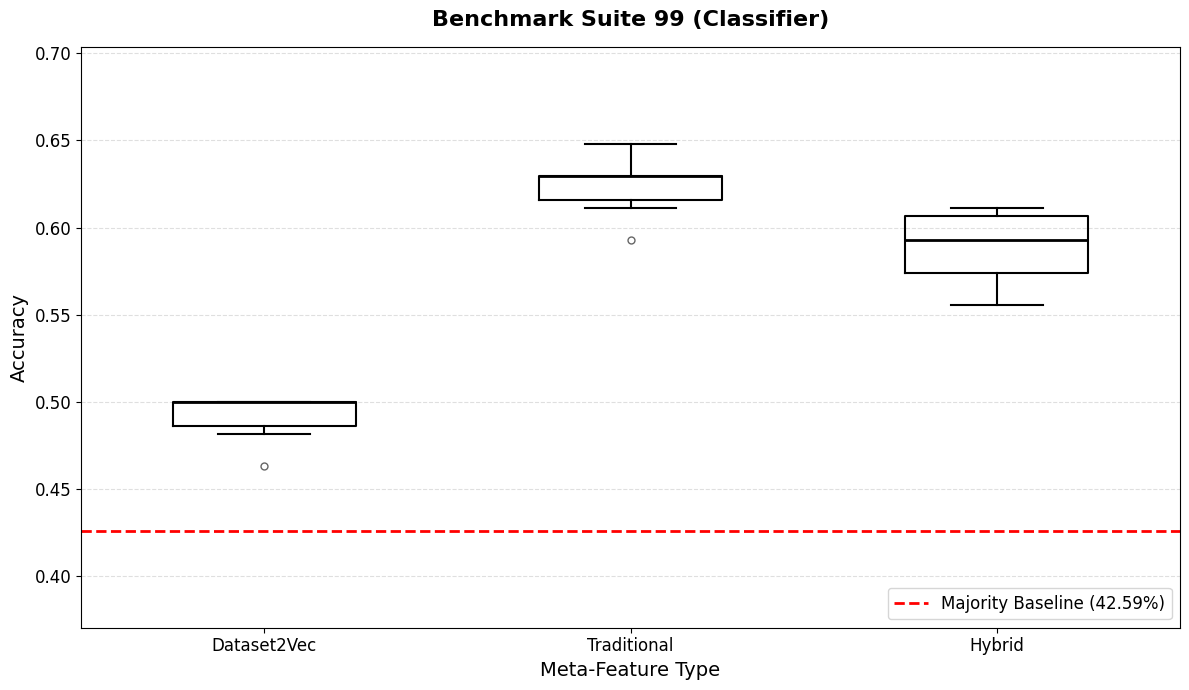

In [4]:
results, majority_acc, summary, (fig, ax) = run_meta_classifier(
    # choosing performance metrics (accuracy or f1)
    metric_name="accuracy",
    # change for algorithm subsets ['decision_tree','random_forest','xgboost','linear_models','support_vector_machine'] or None for all 
    algorithms=None,
    # change number of repeats (numer of meta-models)
    n_repeats=10,
    # Change random seed for reproducibility
    seed = random_seed,
    # Change title for plot
    plot_title="Benchmark Suite 99 (Classifier)"
)

### Meta-Regressor 
1. Trains the meta-regressor  
2. Evaluates meta-regressor performance (LOO-CV with n_repeats)
3. Saves simple statistics and predictions to the results folder


In [5]:
results, baseline_mae, summary_df = run_meta_regressor_multioutput(
    # choosing performance metrics (accuracy or f1)
    metric_name="accuracy",
    # change for algorithm subsets ['decision_tree','random_forest','xgboost','linear_models','support_vector_machine'] or None for all
    algorithms=None,
    # change number of repeats (numer of meta-models)
    n_repeats=10,
    # change random seed for reproducibility
    seed = random_seed,
    # change folder to save regressor results
    output_dir="meta_regressor_results",
)

[INFO] Running self-healing accuracy filler...
[INFO] Loaded accuracy matrix: (54, 5)
[INFO]   Columns: ['random_forest', 'support_vector_machine', 'linear_models', 'xgboost', 'decision_tree']
[INFO]   Index: [1467, 1493, 1494, 1050, 1068]...
[INFO] Initial NaN count: 0
[INFO]   NaN per column: {'random_forest': 0, 'support_vector_machine': 0, 'linear_models': 0, 'xgboost': 0, 'decision_tree': 0}
[INFO] No missing accuracies found.
[INFO] Loaded performance matrix: (54, 5)
[INFO] Algorithms: ['random_forest', 'support_vector_machine', 'linear_models', 'xgboost', 'decision_tree']
[INFO] Valid datasets for regression: 54
[INFO] Performance statistics:
       random_forest  support_vector_machine  linear_models    xgboost  \
count      54.000000               54.000000      54.000000  54.000000   
mean        0.879065                0.876800       0.825241   0.764576   
std         0.107433                0.116266       0.177283   0.238393   
min         0.578125                0.569077  

[INFO]   MAE: 0.1124 ± 0.0013
[INFO]   MSE: 0.0236 ± 0.0005
[INFO]   R²:  -0.0855 ± 0.0224
[INFO] Per-algorithm MAE summary (d2v):
[INFO]   random_forest: 0.0947 ± 0.0010
[INFO]   support_vector_machine: 0.1064 ± 0.0014
[INFO]   linear_models: 0.1304 ± 0.0028
[INFO]   xgboost: 0.1188 ± 0.0016
[INFO]   decision_tree: 0.1117 ± 0.0011
[INFO] Evaluating hybrid meta-regression model...


[INFO]   MAE: 0.0576 ± 0.0007
[INFO]   MSE: 0.0090 ± 0.0002
[INFO]   R²:  0.6756 ± 0.0042
[INFO] Per-algorithm MAE summary (hybrid):
[INFO]   random_forest: 0.0398 ± 0.0007
[INFO]   support_vector_machine: 0.0467 ± 0.0005
[INFO]   linear_models: 0.0848 ± 0.0017
[INFO]   xgboost: 0.0813 ± 0.0021
[INFO]   decision_tree: 0.0356 ± 0.0009
[INFO] Evaluating traditional meta-regression model...


[INFO]   MAE: 0.0577 ± 0.0007
[INFO]   MSE: 0.0093 ± 0.0002
[INFO]   R²:  0.6700 ± 0.0074
[INFO] Per-algorithm MAE summary (traditional):
[INFO]   random_forest: 0.0384 ± 0.0008
[INFO]   support_vector_machine: 0.0459 ± 0.0006
[INFO]   linear_models: 0.0880 ± 0.0022
[INFO]   xgboost: 0.0828 ± 0.0022
[INFO]   decision_tree: 0.0335 ± 0.0017
[INFO] Majority Classifier Baseline:
[INFO]   Best overall algorithm: random_forest
[INFO]   Average performance: 0.8791
[INFO]   Majority classifier accuracy: 0.4259
[INFO] D2V Feature Set - Top-1 Accuracy:
[INFO]   Rep 1: Top-1 Accuracy = 0.3704 (20/54)
[INFO]   Rep 2: Top-1 Accuracy = 0.4815 (26/54)
[INFO]   Rep 3: Top-1 Accuracy = 0.5185 (28/54)
[INFO]   Rep 4: Top-1 Accuracy = 0.4630 (25/54)
[INFO]   Rep 5: Top-1 Accuracy = 0.4630 (25/54)
[INFO]   Rep 6: Top-1 Accuracy = 0.4630 (25/54)
[INFO]   Rep 7: Top-1 Accuracy = 0.4630 (25/54)
[INFO]   Rep 8: Top-1 Accuracy = 0.4074 (22/54)
[INFO]   Rep 9: Top-1 Accuracy = 0.4815 (26/54)
[INFO]   Rep 10: To

### Meta-regressor as classifier  
Uses meta-regressor outputs to visualises them in the same format as the meta-classifier for direct comparison.

Majority Baseline Accuracy: 0.4259

Generating boxplot...

📊 Summary of Meta-Regressor Top-1 Accuracy (as Classifier):
D2v: 0.4574 ± 0.0389
Hybrid: 0.5296 ± 0.0333
Traditional: 0.5130 ± 0.0310

Plot saved to: regresscompress/regressor_as_classifier_boxplot.png


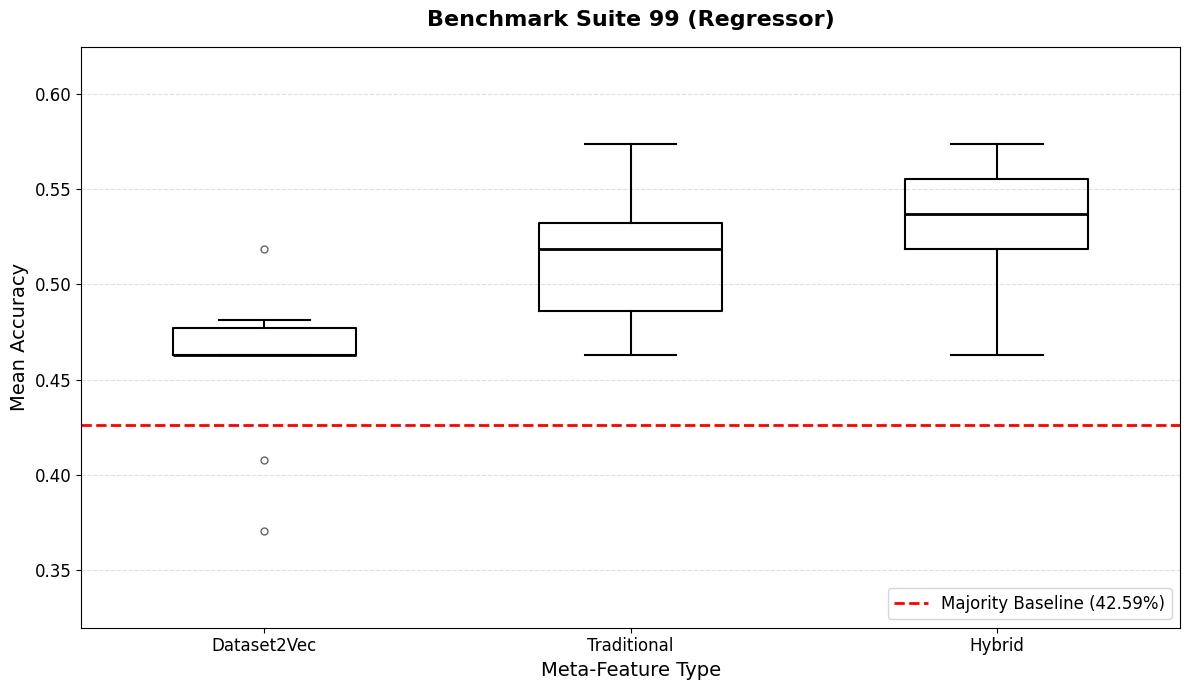

In [ ]:
accuracies, majority_accuracy, summary_df, (fig, ax) = plot_regressor_as_classifier_results(
    # change to where meta_regressor results are stored
    analysis_csv="meta_regressor_results/analysis/top1_accuracy_analysis.csv",
    # change folder to save regressor as classifier
    output_dir="regresscomparison",
    # Change title for plot
    plot_title="Benchmark Suite 99 (Regressor)",
    ylabel="Mean Accuracy"
)

### Storing benchmark suite and random seed data 

In [1]:
selected_suite_info = {"id": 225, "alias": 'OpenML Friendly'}
random_seed = 411

In [2]:
from run_consolidation import consolidate_run_outputs

run_dir = consolidate_run_outputs(
    selected_suite_info=selected_suite_info,
    random_seed=random_seed,
)

run_dir


Moved: ['log', 'meta_classifier_results', 'meta_regressor_results', 'regresscomparison', 'meta_targets', 'qualities', 'runs', 'test_datasets']
Missing: []
Skipped: []


PosixPath('/Users/anukhayri/Desktop/algoselectionpipeline-1/suite_225_seed_411')